In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import h5py
import numpy as np
import astropy.units as u
import astropy.constants as c
from scipy import stats
from tqdm import tqdm

import powerbox as pbox
import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from analysis.limits import get_limits

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [14]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"
stm_d = {
    'pbhhr' : 1e0,
    'pbhacc' : 1e1,
    'pwave' : 1e1,
}
run_name_d = {
    'pbhhr' : "pbhhr-a0.000-250808",
    "pbhacc" : "pbhacc-PRc23-250808",
    'pwave' : "pwave-phot-250808",
}
log10m_d = {
    'pbhhr' : 16.5,
    'pbhacc' : 4.,
    'pwave' : 5.,
}
fn_d = {}
for k, rn in run_name_d.items():
    subfolder = f'log10m{log10m_d[k]:.3f}'
    if stm_d[k] != 1.:
        subfolder += f"_stm{stm_d[k]:.3e}"
    fn_d[k] = f"{outputs_dir}/active/{rn}/{subfolder}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"

multiplier_d = {}
for k, rn in run_name_d.items():
    if stm_d[k] != 1.:
        rn += f"_stm{stm_d[k]:.3e}"
    m_s, _, sigma_s, limit_s = get_limits(rn)
    m = 10**log10m_d[k]
    i = np.argmin(np.abs(m_s - m))
    multiplier_d[k] = sigma_s[i] * np.sqrt(stats.chi2.ppf(.9, df=1))
    print(rn, sigma_s[i], limit_s[i])

bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"

pbhhr-a0.000-250808 11.502853694630604 0.00010639785015275598
pbhacc-PRc23-250808_stm1.000e+01 13.638663869253744 2.2433605732113983e-05
pwave-phot-250808_stm1.000e+01 65.79411375494111 1.3624303142067903e-22


In [6]:
with h5py.File(bkg_fn, 'r') as hf:
    lcfield_bkg = hf['lightcones']['brightness_temp'][()]
    print(hf['lightcones'].keys())

lc_bkg = p21c.LightCone.read(bkg_fn)
z_s = lc_bkg.lightcone_redshifts

<KeysViewHDF5 ['Tk_box', 'Ts_box', 'brightness_temp', 'density', 'xH_box', 'x_e_box']>


In [16]:
lcs = {}
for k, fn in fn_d.items():
    print(fn)
    with h5py.File(fn, 'r') as hf:
        lcs[k] = hf['lightcones']['brightness_temp'][()]

/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhhr-a0.000-250808/log10m16.500/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000_stm1.000e+01/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pwave-phot-250808/log10m5.000_stm1.000e+01/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5


In [17]:
EoR_color = mpl.colors.LinearSegmentedColormap.from_list('EoR', [
    (0.0,  'yellow'),
    (0.25, 'orange'),
    (0.5,  'red'),
    (0.75, 'black'),
    (0.85, 'blue'),
    (0.95, 'cyan'),
    (1.0,  'cyan')
])
vmin, vmax = -60, 20 # 0 at 0.75
EoR_color_small = mpl.colors.LinearSegmentedColormap.from_list('EoRsmall', [
    (0.0, 'black'),
    (0.35, 'blue'),
    (1.0, 'cyan')
])

/tmp/ipykernel_1384859/2967681648.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)


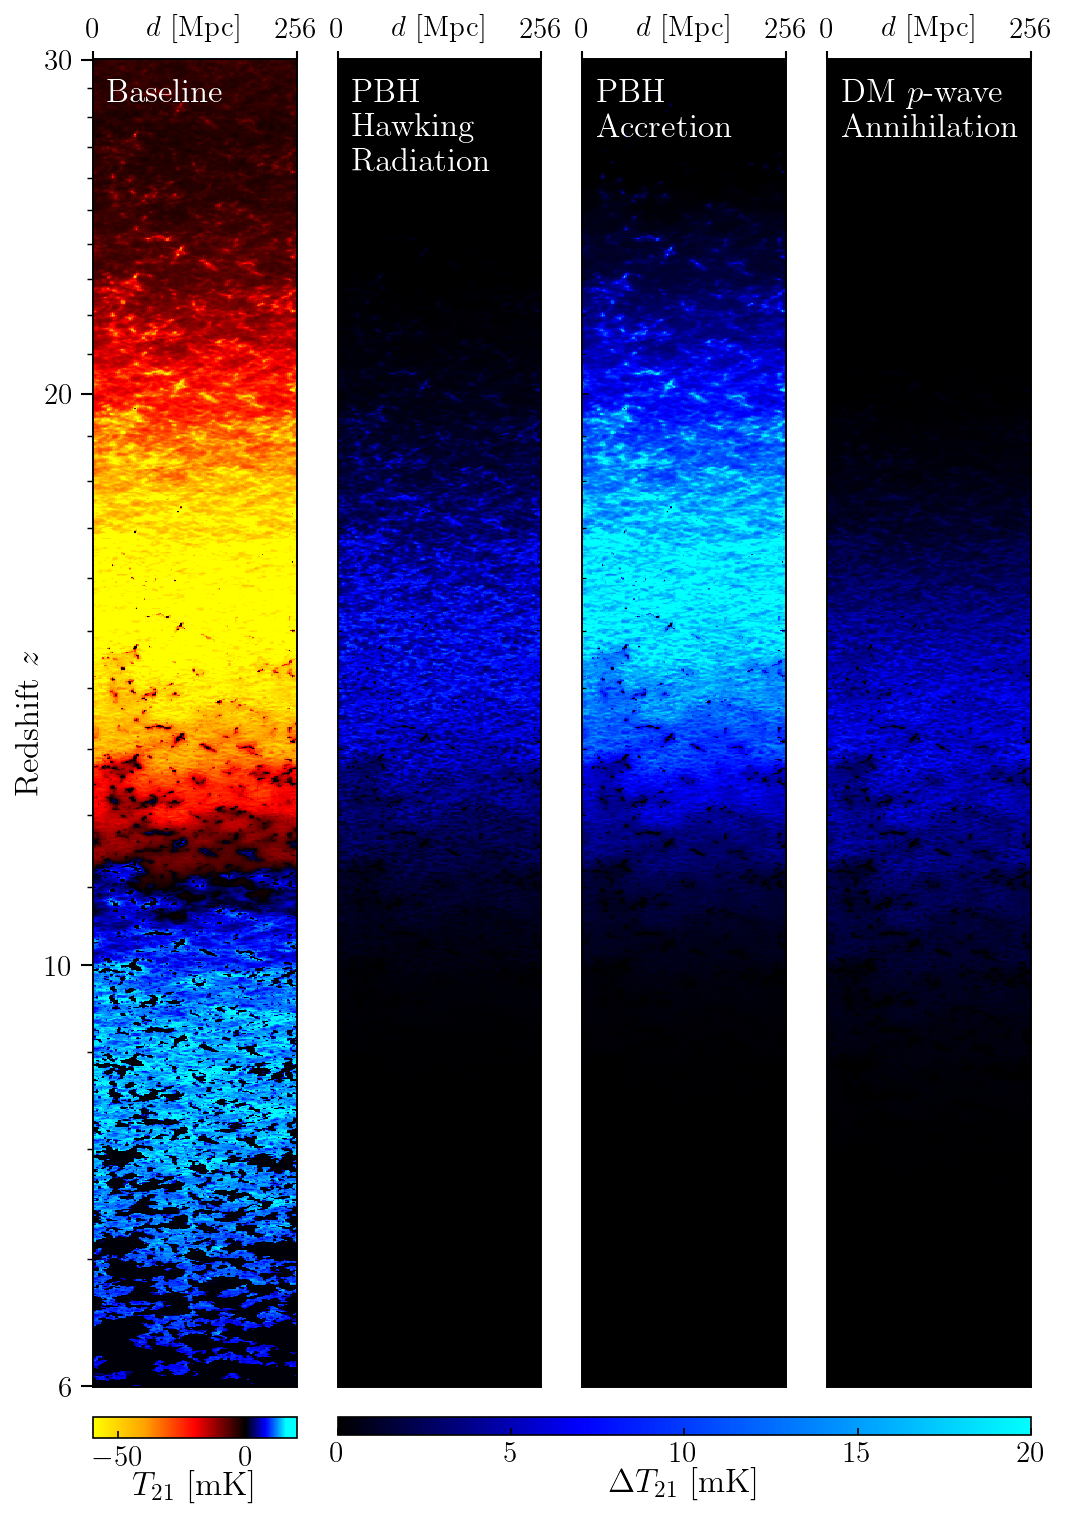

In [19]:
text_d = {
    'pbhhr' : 'PBH \nHawking \nRadiation',
    "pbhacc" : 'PBH \nAccretion',
    'pwave' : r'DM $p$-wave' + '\nAnnihilation',
}

fig, axs = plt.subplots(1, 4, figsize=(7, 10), sharey='row', layout='constrained')

x_s = np.linspace(0, 256, 128)
z_start = 6.
z_end = 30.
i_z_start = np.argmin(np.abs(z_s-z_start)) - 1
i_z_end = np.argmin(np.abs(z_s-z_end)) + 1
z_s_plot = z_s[i_z_start:i_z_end]
lcplot_bkg = lcfield_bkg[:,0,i_z_start:i_z_end].T

ax = axs[0]
im = ax.pcolormesh(x_s, z_s_plot, lcplot_bkg, cmap=EoR_color, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, aspect=10, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$T_{21}$ [mK]', labelpad=0, fontsize=16)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for i, (k, v) in enumerate(lcs.items()):
    lcplot = v[:,0,i_z_start:i_z_end].T
    ax = axs[i+1]
    m = multiplier_d[k]
    lcdiff = (lcplot - lcplot_bkg) * m
    lcdiff[:300, :] = 0
    im = ax.pcolormesh(x_s, z_s_plot, lcdiff, cmap=EoR_color_small, vmin=0, vmax=20)
    ax.text(0.07, 0.985, text_d[k], fontsize=16, color='w', transform=ax.transAxes, ha='left', va='top')

axs[0].text(0.07, 0.985, 'Baseline', fontsize=16, color='w', transform=axs[0].transAxes, ha='left', va='top')

cbar = fig.colorbar(im, ax=axs[1:], aspect=40, pad=0.01, orientation='horizontal')
cbar.ax.set_xlabel(r'$\Delta T_{21}$ [mK]', labelpad=0, fontsize=16)

for ax in axs:
    ax.set(yscale='log', xticks=[])
    axt = ax.twiny()
    axt.set_xticks([0, 256])
    axt.tick_params(axis='x', which='both', direction='out', length=4, width=1)
    axt.set_xlabel(r'$d$ [Mpc]', labelpad=-9)
    ax.invert_yaxis()

# axs[0].set_title(r'No injection $T_b$ [mK]')
# axs[1].set_title(r'Inhom. injection $T_b-$ No injection $T_b$ [mK]')
# axs[2].set_title(r'Hom. injection $T_b-$ No injection $T_b$ [mK]')

axs[0].set_ylabel('Redshift $z$', labelpad=0, fontsize=16)
axs[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].set_yticks([6, 10, 20, 30])  # Major ticks
axs[0].set_yticklabels([6, 10, 20, 30])
axs[0].set_yticks(range(6, 31), minor=True)  # Minor ticks
axs[0].tick_params(axis='y', which='both', direction='out', length=6, width=1)
axs[0].tick_params(axis='y', which='minor', direction='out', length=3, width=0.7)

# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig("../plotting/paper2/inj-scenarios.png", dpi=200)

# Check power spectrum

In [5]:
from analysis.ps import powerspectra

In [7]:
lcs = {}
for k, v in dirs.items():
    fn = f"{outputs_dir}{v}/{inj_fn}"
    print(fn)
    lcs[k] = p21c.LightCone.read(fn)

for k, lc in lcs.items():
    lc.brightness_temp = (lc.brightness_temp - lc_bkg.brightness_temp) * multiplier_d[k] + lc_bkg.brightness_temp

/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhhr-a0.000-250808/log10m16.500/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5
/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pwave-phot-250808/log10m5.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5


In [11]:
ps_d

{'pwave': []}

In [12]:
ps_bkg_s = []
ps_d = {}
for k, lc in lcs.items():
    ps_d[k] = []
z_start_s = np.linspace(5, 23, 10)

for i, ax in enumerate(tqdm(range(10))):
    z_start = z_start_s[i]
    z_end = z_start + 2

    ps_bkg_s.append(powerspectra(lc_bkg, z_start, z_end, n_psbins=30))
    for k, lc in lcs.items():
        ps_d[k].append(powerspectra(lc, z_start, z_end, n_psbins=30))

100%|██████████| 10/10 [04:59<00:00, 29.90s/it]


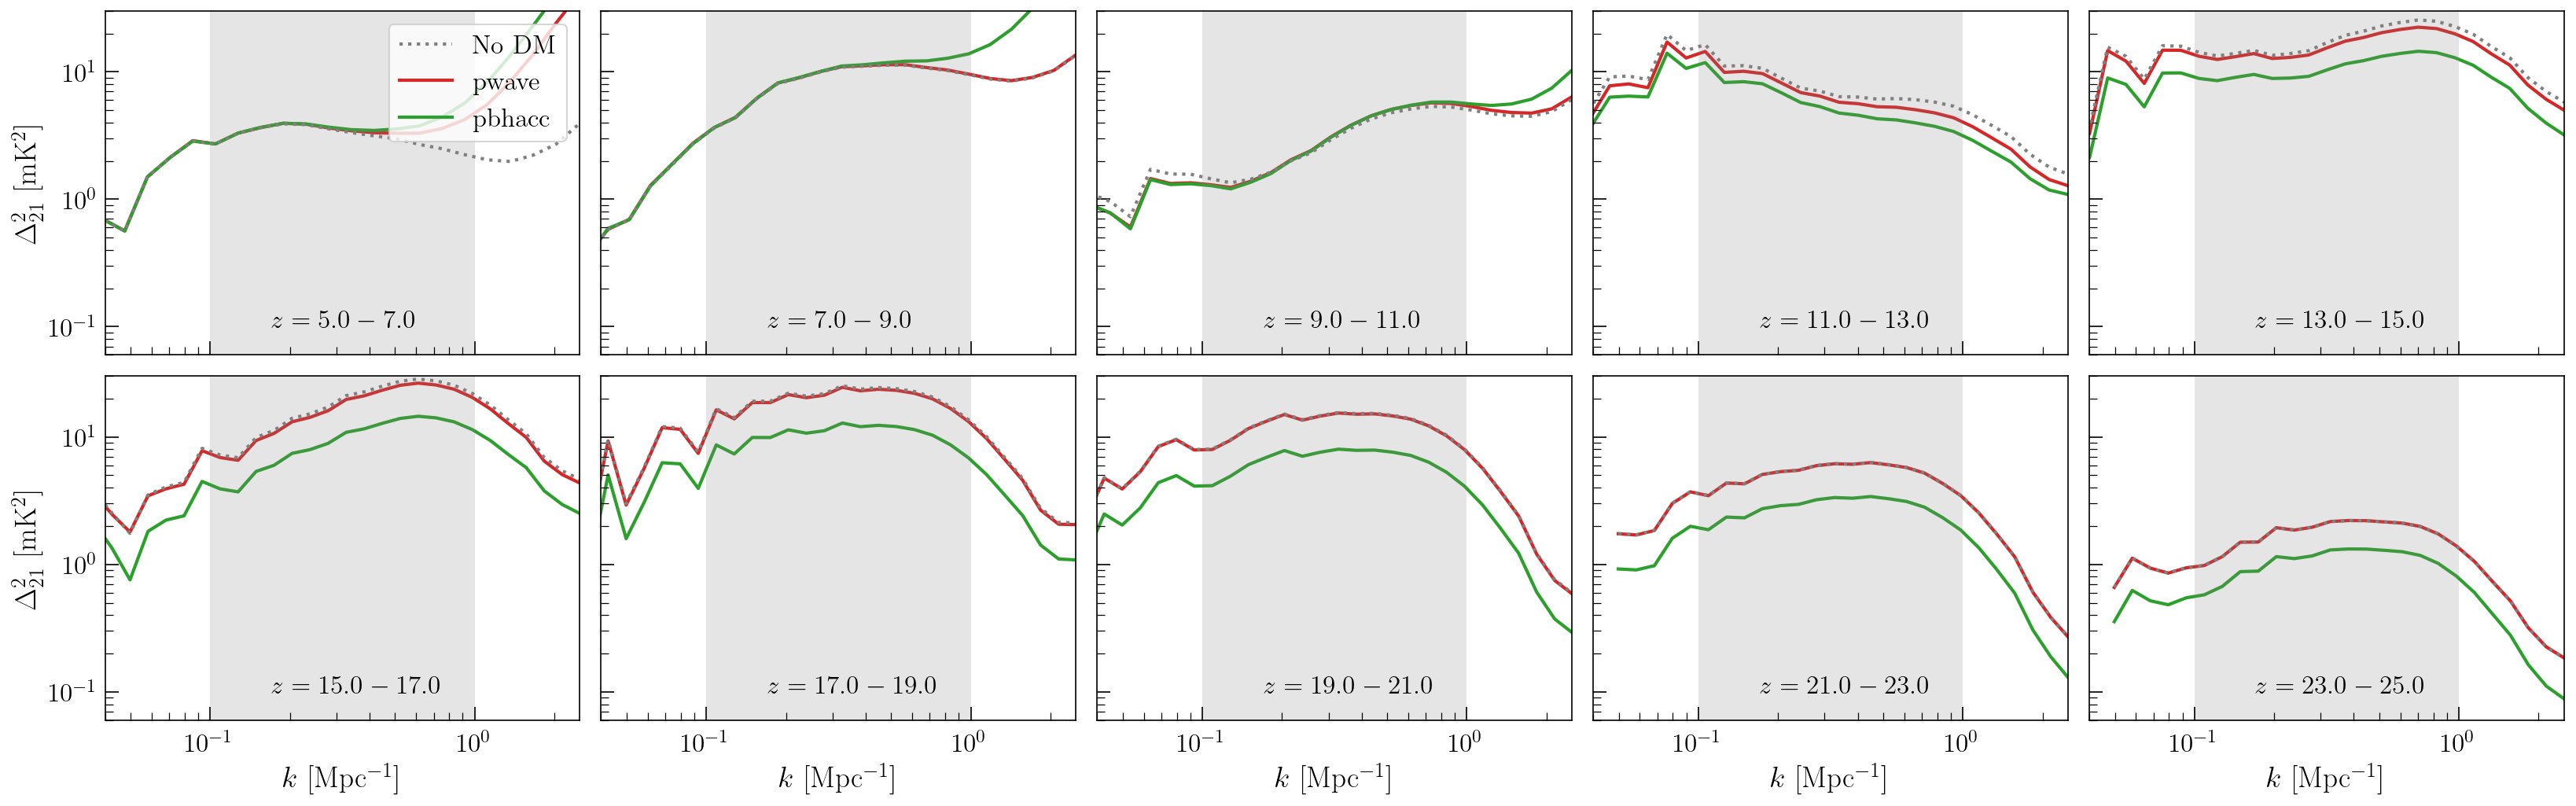

In [14]:
plt.rcParams['xtick.labelsize'] = 16  # Change x-axis label size
plt.rcParams['ytick.labelsize'] = 16  # Change y-axis label size

fig, axs = plt.subplots(2, 5, figsize=(22, 7), sharex=True, sharey=True)

z_start_s = np.linspace(5, 23, 10)

for i, ax in enumerate(axs.flat):
    z_start = z_start_s[i]
    z_end = z_start + 2

    ps_bkg = ps_bkg_s[i]
    ps_0 = ps_d['pwave'][i]
    ps_1 = ps_d['pbhacc'][i]
    label_0 = 'pwave'
    label_1 = 'pbhacc'

    ax.plot(ps_bkg["k"], ps_bkg["delta"], color="gray", ls=':', label='No DM', lw=2, zorder=2)
    ax.plot(ps_0["k"], ps_0["delta"], color="C0", label=label_0, lw=2, zorder=0)
    ax.plot(ps_1["k"], ps_1["delta"], color="C1", label=label_1, lw=2, zorder=1)

    ax.axvspan(0.1, 1, color='gray', ec='none', alpha=0.2)

    ax.text(0.35, 0.08, rf"$z={z_start:.1f}-{z_end:.1f}$", transform=ax.transAxes, fontsize=16)
    ax.set(xscale="log", yscale="log", xlim=(0.04, 2.5))
    ax.tick_params(axis='x', which='major', direction='in', length=8, pad=8)
    ax.tick_params(axis='y', which='major', direction='in', length=8, pad=4)
    ax.tick_params(axis='x', which='minor', direction='in', length=5, pad=8)
    ax.tick_params(axis='y', which='minor', direction='in', length=5, pad=4)


for i in range(5, 10):
    axs.flat[i].set_xlabel(r"$k$ [Mpc$^{-1}$]", fontsize=18)
for i in [0, 5]:
    axs.flat[i].set_ylabel(r"$\Delta_{21}^2$ [mK$^2$]", fontsize=18)

axs.flat[0].legend(fontsize=16, loc='upper right')
axs.flat[0].set(ylim=(6e-2, 3e1))

fig.tight_layout()
# fig.savefig(f"plots/ps_small_inj.pdf", bbox_inches='tight')